In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
########### MODEL CLASSES ###############


class NormalizationLayer(nn.Module):
    def __init__(self, maxnorm, input_shape):
        super(NormalizationLayer, self).__init__()
        self.maxnorm = maxnorm
        self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
    def forward(self, inputs):
        print(self.maxnorm.shape) # 5,1
        print(self.sigmoid(self.a).shape) # 5,1
        print(inputs.shape) # 5,2
        print((self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)).shape) # 5,2
        output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
        return output
    
class NoiseLayer(nn.Module):
    def __init__(self, noise_radius):
        super(NoiseLayer, self).__init__()
        self.noise_radius = noise_radius
        self.alpha = 0.5
        self.beta = 0.5
        
    def spherical_gaussian(self, num_circles):
        x = torch.randn(num_circles, 2)
        beta_distribution = torch.distributions.Beta(self.alpha, self.beta)
        u = beta_distribution.sample((num_circles,2))
        norm = torch.norm(x, dim=1, keepdim=True, p=2)
        noise = x * (u) * self.noise_radius / norm
        return noise

    def forward(self, inputs, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        noise = self.spherical_gaussian(inputs.size(0))
        return inputs + noise
    

class EncoderDecoder(nn.Module):
    def __init__(self, num_circles, larger_radius, smaller_radius):
        super(EncoderDecoder, self).__init__()
        
        self.main_dim = num_circles
        self.latent_dim = 2
        self.R = larger_radius
        self.r = smaller_radius
        self.mid_dim = 30
        self.alpha = 0.5

        self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
        self.noise = NoiseLayer(self.r)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.main_dim, self.mid_dim),
            nn.SELU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.SELU(),
            nn.Linear(self.main_dim, self.latent_dim),
            nn.Tanh()
        )       
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.main_dim),
            nn.ReLU(),
            nn.Linear(self.main_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, alpha, beta):
        encoded = self.encoder(x)
        normed_encoded = self.normalize(encoded)
        noisy_encoded = self.noise(normed_encoded, alpha, beta)
        decoded = self.decoder(noisy_encoded)
        return decoded

    def centres(self, x):
        return self.normalize(self.encoder(x)).detach().numpy()

In [5]:
def one_hot(a, num_classes):
    return torch.tensor(np.eye(num_classes)[a], dtype=torch.float32)

In [6]:
def plot_circles(centres, large_radius, small_radius, save = False, savename=None):
    fig, ax = plt.subplots(figsize = (3, 3))
    ax.axis('off')
    ax.scatter(0,0, color = 'red')
    ax.add_patch(plt.Circle((0,0), radius = large_radius[0], fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    i=0
    for rad, centre in enumerate(centres):
        (x,y) = centre
        #ax.annotate(str(rad+1), (x,y), (x,y), fontsize = 16)
        ax.add_patch(plt.Circle(centre, radius = small_radius[i], fill = False, linewidth = 1.0, color = 'blue'))
        i += 1
    if save:
        plt.savefig(savename)
    plt.show()

def packing_density(centres, r, R = 1, NumSamples = 100000):
    '''
    centres: centres of the spheres [N,2], N: Number of spheres
    r: radius of each circle
    R: radius of enclosing circle
    NumSamples: number of points to be sampled towards density calculation
    '''
    x = np.random.normal(size=[NumSamples, 2])
    u = np.random.uniform(size=[NumSamples, 1])
    norm = np.linalg.norm(x, axis = 1, keepdims=True)
    # r = np.expand_dims(r, axis=(1, 2))
    # r = np.repeat(r, NumSamples, axis=1)
    # r = np.squeeze(r, axis=-1)

    #these points are distributed uniformly inside the circle
    coordinates = x*np.power(u, 1/2)/norm*R[0] 
    centres_reshaped = np.reshape(centres, [1, centres.shape[0], centres.shape[1]])
    coordinates_reshaped = np.reshape(coordinates, [coordinates.shape[0], 1, coordinates.shape[1]])
    distances_from_centres = np.linalg.norm(coordinates_reshaped - centres_reshaped, axis = 2)

        
    return np.sum(np.any(distances_from_centres<r.T, axis=1))/NumSamples

  0%|          | 0/7000 [00:00<?, ?it/s]

torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([

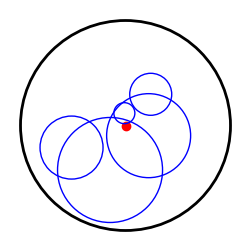

  0%|          | 1/7000 [00:00<1:22:41,  1.41it/s]

##########################
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torc

  0%|          | 2/7000 [00:01<1:08:55,  1.69it/s]

torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([

  0%|          | 2/7000 [00:01<1:31:31,  1.27it/s]

torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
torch.Size([5, 2])


KeyboardInterrupt: 

In [7]:
# Parameters
num_circles = 5  ## r = 0.5, 0.4, 0.3, 0.2, 0.1
small_radius = torch.tensor(([0.5], [0.4], [0.3], [0.2], [0.1]))
large_radius = torch.ones_like(small_radius)*1.0
BATCHES = 200
EPOCHS = 7000

# Initialize input data and loss function
eye = one_hot(np.arange(0, num_circles), num_circles)
Input = eye.repeat(BATCHES, 1, 1)

model = EncoderDecoder(num_circles, large_radius, small_radius)


loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
optim2 = torch.optim.Adam(model.parameters(), lr=0.00005)
alpha = 2
beta = 8

# Training loop
for epoch in tqdm(range(EPOCHS)):
    if epoch == 500 :
        alpha = 4
        beta = 8
    if epoch == 1000 :
        alpha = 8
        beta = 8
    if epoch == 2000 :
        alpha = 2
        beta = 2
    if epoch == 3000 :
        alpha = 0.5
        beta = 0.5
    if epoch < 4000:
        for inputs in Input:           
            optim.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim.step()
    if epoch >= 4000:
            optim2.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim2.step()
    if epoch % 100 == 0:
        print(f"Epcoh {epoch}") 
        centres = model.centres(eye)
        print(f"Packing Density : {packing_density(centres, small_radius.numpy(), large_radius.numpy())}")
        print(f"Circle Config : ")
        plot_circles(centres, large_radius, small_radius)
        print("##########################")

centres = model.centres(eye)
plot_circles(centres, large_radius, small_radius)

In [ ]:
# ########### MODEL CLASSES ###############


# class NormalizationLayer(nn.Module):
#     def __init__(self, maxnorm, input_shape):
#         super(NormalizationLayer, self).__init__()
#         self.maxnorm = maxnorm
#         self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
#         self.sigmoid = nn.Sigmoid()
#         self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
#     def forward(self, inputs):
#         output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
#         return output
    
# class NoiseLayer(nn.Module):
#     def __init__(self, noise_radius):
#         super(NoiseLayer, self).__init__()
#         self.noise_radius = noise_radius
#         self.alpha = 0.5
        
#     def spherical_gaussian(self, num_circles):
#         x = torch.randn(num_circles, 2)
#         u = torch.rand(num_circles, 1)
#         norm = torch.norm(x, dim=1, keepdim=True, p=2)
#         noise = x * (u.pow(self.alpha)) * self.noise_radius / norm
#         return noise

#     def forward(self, inputs, alpha):
#         self.alpha = alpha
#         noise = self.spherical_gaussian(inputs.size(0))
#         return inputs + noise
    

# class EncoderDecoder(nn.Module):
#     def __init__(self, num_circles, larger_radius, smaller_radius):
#         super(EncoderDecoder, self).__init__()
        
#         self.main_dim = num_circles
#         self.latent_dim = 2
#         self.R = larger_radius
#         self.r = smaller_radius
#         self.mid_dim = 30
#         self.alpha = 0.5

#         self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
#         self.noise = NoiseLayer(self.r)
        
#         self.encoder = nn.Sequential(
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.SELU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.SELU(),
#             nn.Linear(self.main_dim, self.latent_dim),
#             nn.Tanh()
#         )       
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.main_dim),
#             nn.ReLU(),
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.ReLU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.Softmax(dim=1)
#         )
        
#     def forward(self, x, alpha):
#         self.alpha = alpha
#         encoded = self.encoder(x)
#         normed_encoded = self.normalize(encoded)
#         noisy_encoded = self.noise(normed_encoded, alpha)
#         decoded = self.decoder(noisy_encoded)
#         return decoded

#     def centres(self, x):
#         return self.normalize(self.encoder(x)).detach().numpy()